In [ ]:
import torchvision
import torch
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
import numpy as np
from torch.optim import lr_scheduler
import time

In [ ]:
from glob import glob
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import optim
from torchvision import models
from torch import nn
import torch
from torch.optim import lr_scheduler
import time
import copy
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MLDM project

/content/drive/MyDrive/MLDM project


In [ ]:
n_epochs = 3
batch_size_train = 1024
batch_size_test = 1024
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

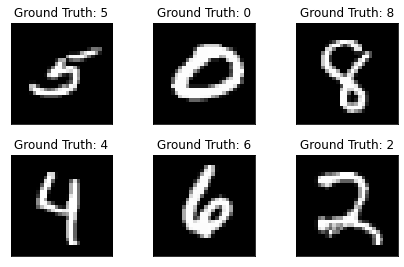

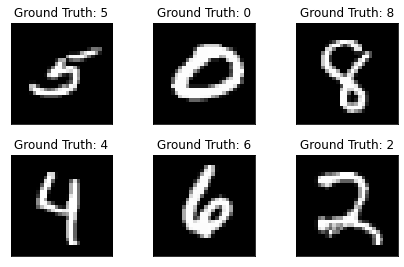

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1) 
        output = self.out(x)
        return output, x    # return x for clustering

In [ ]:
net = Net()

In [ ]:
dataloaders = {
    'train':train_loader, 
    'val': test_loader
}
dataset_sizes = {
    'train':60000,
    'val':10000
}

In [ ]:
criterion_class = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=0.0015)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

In [ ]:
net = net.to(device)

In [ ]:
pca = IncrementalPCA(n_components=512, batch_size=512, whiten=True)
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=512, max_iter=1000, init_size=3*100)

In [ ]:
def train_model(model, criterion_class, optimizer, num_epochs=25, c=1000):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = 5
    first_time = True
    # флаг для определения первого батча


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = []
            train_acc = []
            val_acc = []
            cluster_acc = []

           
            # Iterate over data.
            for inputs, class_labels in dataloaders[phase]:

                inputs = inputs.to(device)
                class_labels = class_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
              
                    class_out, vectors = model(inputs)
                    _, preds = torch.max(class_out, 1)
                    vectors = vectors.to(cpu)
                    vectors_np = vectors.detach().numpy()
                    vectors_np = StandardScaler().fit_transform(vectors_np)
                    cluster_labels = None

                    # кластеризация только на первом батче
                    if first_time:
                      cluster_labels = kmeans.fit_predict(vectors_np)
                      first_time = False
                    else:
                      cluster_labels = kmeans.predict(vectors_np)

                    
                    clust_sam = cluster_labels.copy()
                    cluster_labels = torch.from_numpy(cluster_labels).long().to(device)
                    loss = criterion_class(class_out,cluster_labels)
                    
                    if (phase == 'train'):
                        loss.backward()
                        optimizer.step()
                        cluster = True

                    class_labels_clone = class_labels.clone().to(cpu).detach().numpy()
                    preds_clone = preds.clone().to(cpu).detach().numpy()

                    my_score = normalized_mutual_info_score(class_labels_clone,preds_clone )
                    cluster_acc.append(normalized_mutual_info_score(class_labels_clone,clust_sam))



                running_loss += loss.item() * inputs.size(0)
                running_corrects.append(normalized_mutual_info_score(class_labels_clone,preds_clone ))


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = np.mean(running_corrects)
            plt.plot(running_corrects)
            plt.xlabel(f'number of batch fro phase {phase}')
            plt.grid(True)
            plt.show()
            print(f'{phase} Loss: {epoch_loss:.4f} acc: {epoch_acc:.4f} cluster_acc: {np.mean(cluster_acc)}')

            if phase == 'val' and epoch_loss < best_epoch_loss:
                best_epoch_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())





    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best : {:4f}'.format( best_epoch_loss))


    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), './models/model')
    return model

Epoch 0/4
----------


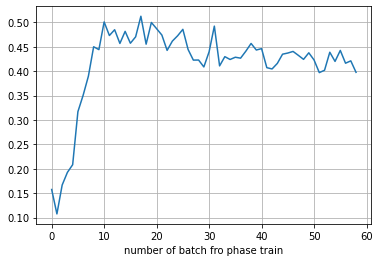

train Loss: 0.5052 acc: 0.4158 cluster_acc: 0.43008575067805493


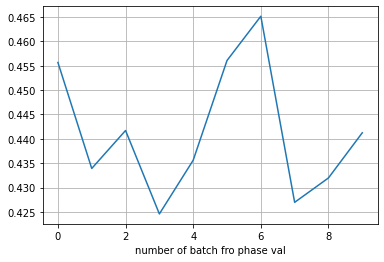

val Loss: 0.1595 acc: 0.4413 cluster_acc: 0.42283123507458764
Epoch 1/4
----------


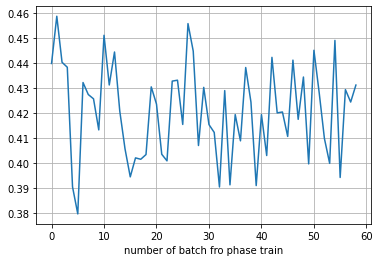

train Loss: 0.1300 acc: 0.4207 cluster_acc: 0.41534540675482745


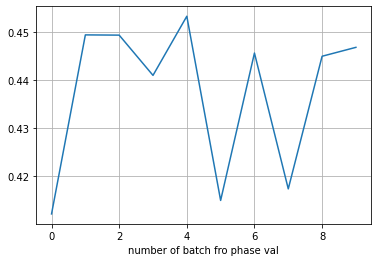

val Loss: 0.1612 acc: 0.4374 cluster_acc: 0.4199076020485662
Epoch 2/4
----------


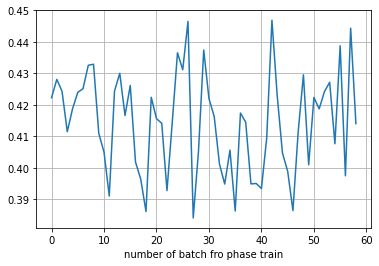

train Loss: 0.1127 acc: 0.4145 cluster_acc: 0.41156368944548366


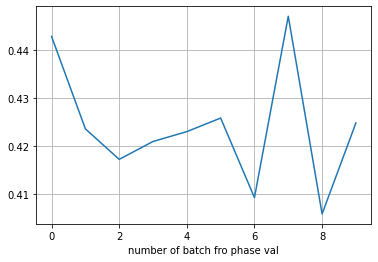

val Loss: 0.1075 acc: 0.4241 cluster_acc: 0.41712789875566275
Epoch 3/4
----------


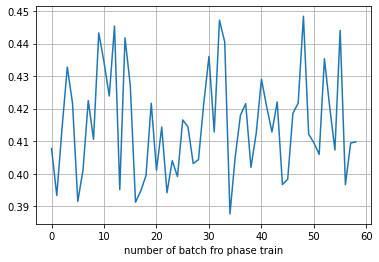

train Loss: 0.1176 acc: 0.4150 cluster_acc: 0.41226653486069714


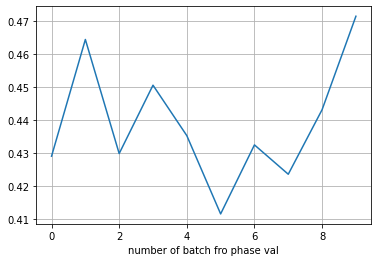

val Loss: 0.1760 acc: 0.4391 cluster_acc: 0.42483612143701066
Epoch 4/4
----------


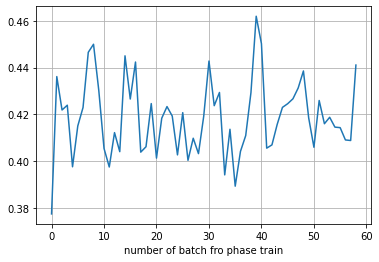

train Loss: 0.1132 acc: 0.4187 cluster_acc: 0.41434792302083584


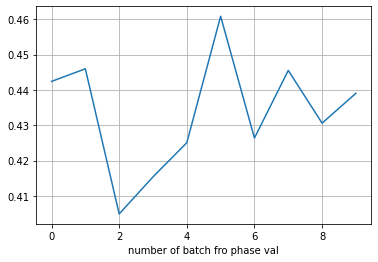

val Loss: 0.1315 acc: 0.4336 cluster_acc: 0.4209836674359632
Training complete in 2m 6s
Best : 0.107472


In [ ]:
model_ft_tf = train_model(net, criterion_class, optimizer_ft, num_epochs=5)